In [69]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import hr_full as smf
import surrogate as sr
import sample as sm
import matplotlib.pyplot as plt
import pandas as pd
import torch
import wasserstein_torch as w2
from joblib import Parallel, delayed
import csv
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
repo = '..'

L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
test = np.load('{}/test.npy'.format(L63_data_folder))
L0, L1, D, D_r = 0.4, 3.5, 3, 300
sampler_full = smf.GoodRowSampler(L0, L1, train.T)
sampler = sm.MatrixSampler(L0, L1, train.T)
training_points = 20000
N_max = train.shape[1]
beta = 4e-5
n_exprs = 500


# @ut.timer
def get_model_full(percent=100):
    W_in, b_in = sampler_full.sample(D_r); 
    model = sr.SurrogateModel_LR(D, D_r, W_in, b_in)
    random_index = np.random.randint(N_max-training_points-1)
    model.compute_W(train[:, random_index:random_index+training_points], beta=beta);
    return model

def get_model(percent=100):
    W_ins, b_ins = sampler.sample_parallel([D_r, 0, 0], 1); 
    model = sr.SurrogateModel_LR(D, D_r, W_ins[0], b_ins[0])
    random_index = np.random.randint(N_max-training_points-1)
    model.compute_W(train[:, random_index:random_index+training_points], beta=beta);
    return model

def compute_R(model, threshold=0.2):
    U = train[:, :5000]
    phi = np.abs(model.W_in @ U + model.b_in[:, np.newaxis])
    maxs = np.max(phi, axis=1)
    mins = np.min(phi, axis=1)
    return (maxs - mins).sum() / D_r 


def compute_error(model, validation_, error_threshold=0.05, dt=0.02, Lyapunov_time=1/0.91):
    """
    Description: computes forecast time tau_f for the computed surrogate model

    """
    validation_points = validation_.shape[1]
    prediction = model.multistep_forecast(validation_[:, 0], validation_points)
    se_ = np.linalg.norm(validation_ - prediction, axis=0)**2 / np.linalg.norm(validation_, axis=0)**2

    l = np.argmax(se_ > error_threshold)  
    if l == 0:
        tau_f_se = validation_points
    else:
        tau_f_se = l-1

    tau_f_se *= (dt / Lyapunov_time)
    return tau_f_se

@ut.timer
def compute_R_and_tau_full():
    model = get_model_full()
    R = compute_R(model)
    tau = compute_error(model, test[np.random.randint(test.shape[0])])
    return R, tau

@ut.timer
def compute_R_and_tau():
    model = get_model()
    R = compute_R(model)
    tau = compute_error(model, test[np.random.randint(test.shape[0])])
    return R, tau

results = np.array(Parallel(n_jobs=-1)(delayed(compute_R_and_tau_full)() for _ in range(n_exprs)))
R, tau = results[:, 0], results[:, 1]
np.save('../data/R_full/R_full.npy', R)
np.save('../data/R_full/tau_full.npy', tau)

results = np.array(Parallel(n_jobs=-1)(delayed(compute_R_and_tau)() for _ in range(n_exprs)))
R, tau = results[:, 0], results[:, 1]
np.save('../data/R_full/R.npy', R)
np.save('../data/R_full/tau.npy', tau)

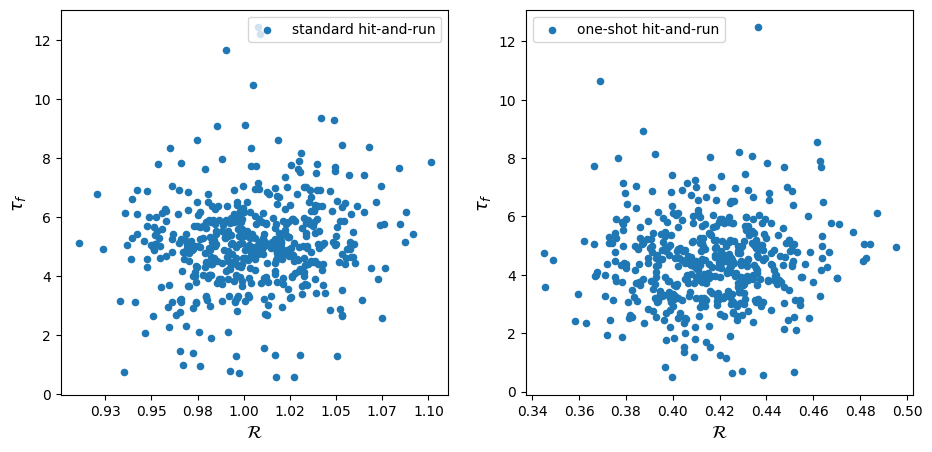

In [72]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

Rf = np.load('../data/R_full/R_full.npy')
tauf = np.load('../data/R_full/tau_full.npy')
ax1.scatter(Rf, tauf, s=20, label=r"standard hit-and-run")
ax1.set_xlabel(r'$\mathcal{R}$', fontsize=13)
ax1.set_ylabel(r'$\tau_f$', fontsize=13)
ax1.legend()
# Set the x-axis tick labels to display 2 decimal points.
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

R = np.load('../data/R_full/R.npy')
tau = np.load('../data/R_full/tau.npy')
ax2.scatter(R, tau, s=20, label="one-shot hit-and-run")
ax2.set_xlabel(r'$\mathcal{R}$', fontsize=13)
ax2.set_ylabel(r'$\tau_f$', fontsize=13)
ax2.legend()
# Set the x-axis tick labels to display 2 decimal points.
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig("../data/R_tau_standard_vs_oneshot.png", bbox_inches="tight", dpi=300)

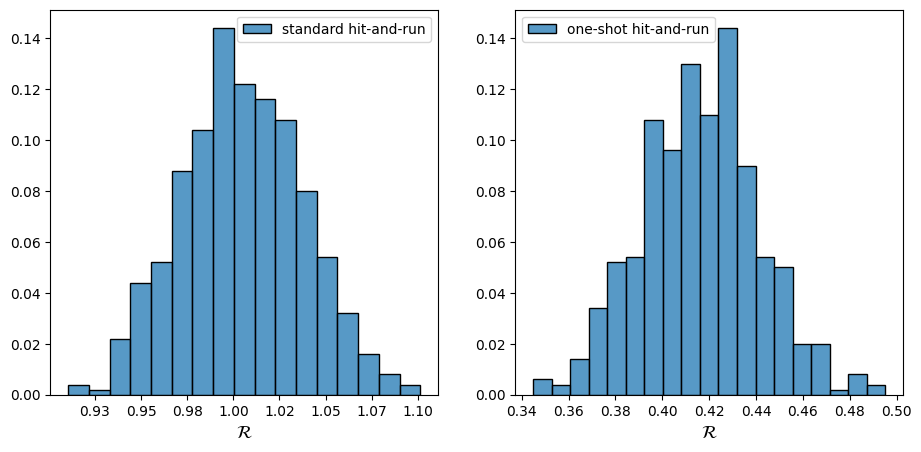

In [71]:

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

Rf = np.load('../data/R_full/R_full.npy')
tauf = np.load('../data/R_full/tau_full.npy')
sns.histplot(Rf, ax=ax1, label=r"standard hit-and-run", stat='probability')
ax1.set_xlabel(r'$\mathcal{R}$', fontsize=13)
ax1.set_ylabel(r'', fontsize=13)
ax1.legend()
# Set the x-axis tick labels to display 2 decimal points.
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

R = np.load('../data/R_full/R.npy')
tau = np.load('../data/R_full/tau.npy')
sns.histplot(R, ax=ax2, label="one-shot hit-and-run", stat='probability')
ax2.set_xlabel(r'$\mathcal{R}$', fontsize=13)
ax2.set_ylabel(r'', fontsize=13)
ax2.legend()
# Set the x-axis tick labels to display 2 decimal points.
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig("../data/plots/R_standard_vs_oneshot.png", bbox_inches="tight", dpi=300)